In [82]:
import tensorflow as tf
import keras as ks
from keras import models
from keras import metrics
import pandas as pd
import numpy as np
import sklearn
from sklearn import model_selection

In [83]:
rawdata=pd.read_csv('/content/META.csv').round(3)

In [84]:
rawdata=rawdata.dropna()
rawdata

,Date,High,Low,Adj Close,Open,Volume,Close,Interest,Currency,Inflation,Day,Month
0,2012-05-21,36.66,33.00,34.03,36.53,168192700,34.03,1.80,0.629,1.7,21,5
1,2012-05-22,33.59,30.94,31.00,32.61,101786600,31.00,1.80,0.629,1.7,22,5
2,2012-05-23,32.50,31.36,32.00,31.37,73600000,32.00,1.80,0.629,1.7,23,5
3,2012-05-24,33.21,31.77,33.03,32.95,50237200,33.03,1.80,0.629,1.7,24,5
4,2012-05-25,32.95,31.11,31.91,32.90,37149800,31.91,1.80,0.629,1.7,25,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2727,2023-03-24,207.58,203.55,206.01,205.18,27733000,206.01,3.66,0.824,5.0,24,3
2728,2023-03-27,205.86,201.36,202.84,204.81,18527200,202.84,3.66,0.824,5.0,27,3
2729,2023-03-28,201.03,197.90,200.68,200.15,19127300,200.68,3.66,0.824,5.0,28,3
2730,2023-03-29,205.72,202.54,205.35,203.56,18851100,205.35,3.66,0.824,5.0,29,3


In [85]:
data=pd.DataFrame()
data['Open']=rawdata['Open'].astype(np.float64)
data['High']=rawdata['High'].astype(np.float64)
data['Low']=rawdata['Low'].astype(np.float64)
data['Close']=rawdata['Close'].astype(np.float64)
data['Currency']=rawdata['Currency'].astype(np.float64)
data['Interest']=rawdata['Interest'].astype(np.float64)
data['Inflation']=rawdata['Inflation'].astype(np.float64)
data['Day']=rawdata['Day'].astype(np.int64)
data['Month']=rawdata['Month'].astype(np.int64)
data.head()

,Open,High,Low,Close,Currency,Interest,Inflation,Day,Month
0,36.53,36.66,33.00,34.03,0.629,1.8,1.7,21,5
1,32.61,33.59,30.94,31.00,0.629,1.8,1.7,22,5
2,31.37,32.50,31.36,32.00,0.629,1.8,1.7,23,5
3,32.95,33.21,31.77,33.03,0.629,1.8,1.7,24,5
4,32.90,32.95,31.11,31.91,0.629,1.8,1.7,25,5


In [86]:
train=data.iloc[:int(0.8*len(data))]
test=data.iloc[int(0.8*len(data)):]

In [7]:
def sliding_window(stockdata):
  window_size=7
  windowed_data=[]
  for i in range(len(stockdata)-window_size):
      window=stockdata[i:i+window_size]
      windowed_data.append(window)
  return np.array(windowed_data)

In [6]:
def dataprep(data):
  X=sliding_window(data)
  Y=data['Close'][7:]
  Z = X.reshape(X.shape[0],-1)
  Y_reshaped = np.expand_dims(Y,axis=1)
  combined = np.concatenate((Z, Y_reshaped), axis=-1)
  shuffled = sklearn.utils.shuffle(combined)
  return shuffled[:, :-1].reshape(shuffled.shape[0],X.shape[1], X.shape[2]),shuffled[:, -1].reshape(shuffled.shape[0], 1)

In [53]:
#run to shuffle batches 
X,Y=dataprep(train)
TestingX,TestingY=dataprep(test)

In [87]:
#run to keep batches ordered
X=sliding_window(train)
Y=train['Close'][7:]
TestingX=sliding_window(test)
TestingY=test['Close'][7:]

In [88]:
x_train,x_test,y_train,y_test=model_selection.train_test_split(X,Y,test_size=0.2)

In [89]:
metric=[metrics.RootMeanSquaredError(),metrics.MeanAbsoluteError(),metrics.MeanAbsolutePercentageError(),metrics.MeanSquaredLogarithmicError()]
def modelbuild():
    model = models.Sequential()
    model.add(ks.layers.LSTM(256, return_sequences=True,activation='relu', input_shape=(7,9),dropout=0.1,recurrent_dropout=0.1))
    model.add(ks.layers.SimpleRNN(32,activation='relu'))
    model.add(ks.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=metric)
    return model

In [57]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_53 (LSTM)              (None, 7, 256)            272384    
                                                                 
 dense_18 (Dense)            (None, 7, 1)              257       
                                                                 
Total params: 272,641
Trainable params: 272,641
Non-trainable params: 0
_________________________________________________________________


In [90]:
model=modelbuild()
stop = ks.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test),callbacks=[stop])
#history = model.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test))

test_loss, rmse, mae, mape, msle = model.evaluate(x_test, y_test, verbose=2)

print('\nMean Squared Error: ', test_loss)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)
print('Mean Absolute Percentage Error: ', mape)
print('Mean Squared Logarithmic Error: ', msle)

Epoch 1/10
55/55 [==============================] - 10s 111ms/step - loss: 485.7907 - root_mean_squared_error: 22.0407 - mean_absolute_error: 12.0426 - mean_absolute_percentage_error: 10.0329 - mean_squared_logarithmic_error: 0.0524 - val_loss: 153.2654 - val_root_mean_squared_error: 12.3800 - val_mean_absolute_error: 9.2195 - val_mean_absolute_percentage_error: 6.4116 - val_mean_squared_logarithmic_error: 0.0057
Epoch 2/10
55/55 [==============================] - 5s 96ms/step - loss: 55.8844 - root_mean_squared_error: 7.4756 - mean_absolute_error: 5.2568 - mean_absolute_percentage_error: 4.7048 - mean_squared_logarithmic_error: 0.0036 - val_loss: 349.2033 - val_root_mean_squared_error: 18.6870 - val_mean_absolute_error: 15.1983 - val_mean_absolute_percentage_error: 11.1354 - val_mean_squared_logarithmic_error: 0.0157
Epoch 3/10
55/55 [==============================] - 4s 72ms/step - loss: 48.8315 - root_mean_squared_error: 6.9880 - mean_absolute_error: 4.7911 - mean_absolute_percentag

In [91]:
test_loss, rmse, mae, mape, msle = model.evaluate(TestingX,TestingY,verbose=1)
print('\nMean Squared Error: ', test_loss)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)
print('Mean Absolute Percentage Error: ', mape)
print('Mean Squared Logarithmic Error: ', msle)
print("Want to save model?")
c=input()
if c=='y':
  ks.Model.save(model,'/content/models')

17/17 [==============================] - 1s 32ms/step - loss: 462.4416 - root_mean_squared_error: 21.5045 - mean_absolute_error: 18.0912 - mean_absolute_percentage_error: 7.3550 - mean_squared_logarithmic_error: 0.0079

Mean Squared Error:  462.44158935546875
Root Mean Squared Error:  21.50445556640625
Mean Absolute Error:  18.091182708740234
Mean Absolute Percentage Error:  7.355005741119385
Mean Squared Logarithmic Error:  0.00786917470395565
Want to save model?
y


86/86 [==============================] - 2s 24ms/step


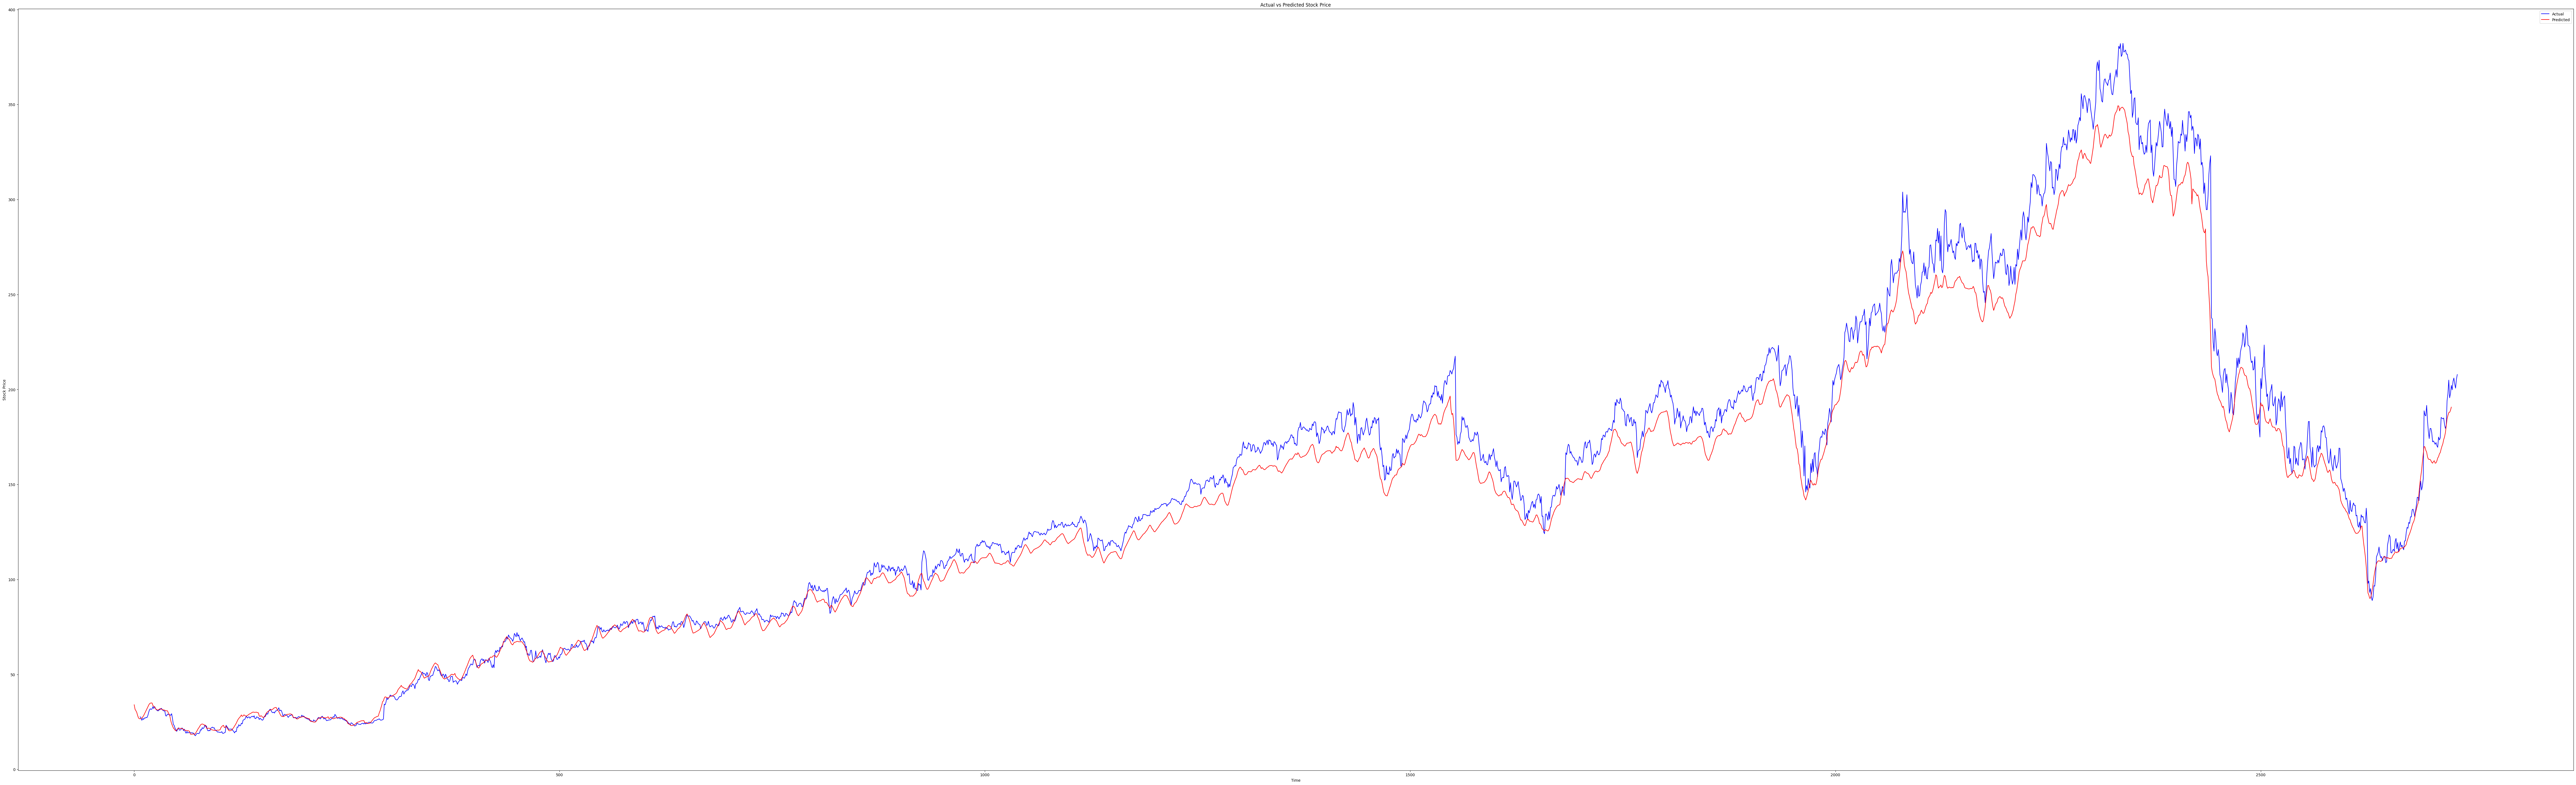

In [92]:
predicted_prices=model.predict(sliding_window(data))
actual_prices=data['Close'][7:]
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(120,36))
plt.plot(actual_prices, color='blue', label='Actual')
plt.plot(predicted_prices, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Price')
plt.legend()
plt.show()